In [57]:
import sys,os
add_path = os.path.abspath('../python')
import matplotlib as mpl
from matplotlib import colors
if not add_path in sys.path:
    sys.path.append(add_path)
print(sys.path.index(add_path))
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.interpolation'] = 'hanning'
plt.rcParams['image.cmap'] = 'gray'
import segbench
from segbench import interp3, edgeNms3d, correspondVoxels, correspondPixels
import skimage
from skimage.filters import gaussian_filter
import SimpleITK as sitk
def normalimg(E):
    if (E.max()-E.min())>0:
        return (E-E.min())/(E.max()-E.min()+1e-10)
    else:
        return E
def edgeOrientation(E,s=1):
    D = normalimg(gaussian_filter(E,s))
    Ox,Oy,Oz = np.gradient(D)
    M = np.sqrt(Ox*Ox+Oy*Oy+Oz*Oz)
    Ox,Oy,Oz = (Ox,Oy,Oz)/M
    theta = np.arctan(Oy/(Oz+1e-5))
    phi = np.arctan(Oz/(M+1e-5))
    Px= np.sin(theta)*np.cos(phi)
    Py= np.sin(theta)*np.sin(phi)
    Pz= np.cos(phi)
    return Px,Py,Pz,D
    
def plot_vol(V,num_frames=4):
    vmin,vmax = V.min(),V.max()
    ds = V.shape
    frame_list = map(int,np.arange(0,ds[2],np.floor(ds[2]/num_frames)))
    for i,f in enumerate(frame_list):
        ax = plt.subplot(1,ds[2],i+1)
        ax.imshow(V[:,:,f],vmin=vmin,vmax=vmax)
        ax.set_xticklabels([]);ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')
        
def plot_vol_overlay(im,red=None,green=None,blue=None,num_frames=4,alpha=.5):

    ds = im.shape
    z = np.zeros_like(im)
    red = z if red is None else normalimg(red)*im.max()
    blue = z if blue is None else normalimg(blue)*im.max()
    green = z if green is None else normalimg(green)*im.max()
    
    frame_list = map(int,np.arange(0,ds[2],np.floor(ds[2]/num_frames)))
    vmax,vmin = im.max(),im.min()
    Is = [im[:,:,i] for i in frame_list]
#     red_lst = [np.dstack((np.ma.masked_where(red[:,:,i]>0,red[:,:,i]),
#                           z[:,:,i],z[:,:,i])) for i in frame_list]
    red_lst = [np.ma.masked_where(red[:,:,i]==0,red[:,:,i]) for i in frame_list]
    green_lst = [np.ma.masked_where(green[:,:,i]==0,green[:,:,i]) for i in frame_list]
    blue_lst = [np.ma.masked_where(blue[:,:,i]==0,blue[:,:,i]) for i in frame_list]
    for i,I in enumerate(Is):
        ax = plt.subplot(1,ds[2],i+1)
        ax.imshow(I,cmap=mpl.cm.Greys_r,vmin=vmin,vmax=vmax)
        ax.imshow(red_lst[i],cmap=colors.ListedColormap(['red']),
                  interpolation='hanning',alpha=alpha)
        ax.imshow(green_lst[i],cmap=colors.ListedColormap(['green']),
          interpolation='hanning',alpha=alpha)
        ax.imshow(blue_lst[i],cmap=colors.ListedColormap(['blue']),
          interpolation='hanning',alpha=alpha)
        ax.set_xticklabels([]);ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none');ax.xaxis.set_ticks_position('none')
def thin(img):
    return sitk.GetArrayFromImage(sitk.BinaryThinning(sitk.GetImageFromArray((img>0).astype(int))))*img
def dilate(img):
    return sitk.GetArrayFromImage(sitk.BinaryDilate(sitk.GetImageFromArray((img>0).astype(int))))

14


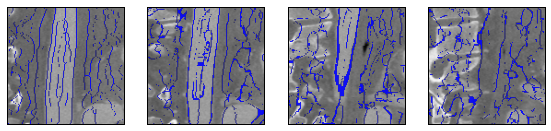

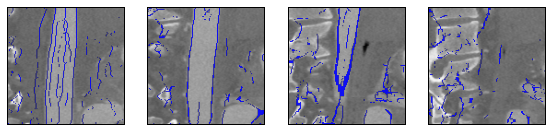

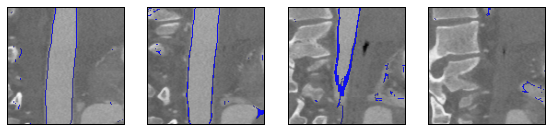

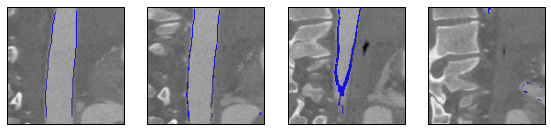

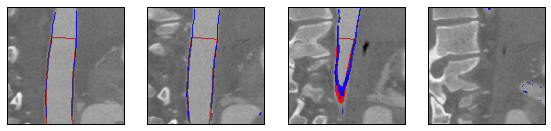

In [67]:
num_frames = 4
plt.rcParams['image.interpolation'] = 'hanning'
I = np.load("3dEdgeIM.npy")
E = np.load("3dEdgeE.npy")
GT = np.load("3dEdgeGT.npy")
E = normalimg(E)
Eb = gaussian_filter(E,2)
vmin,vmax = E.min(),E.max()
dX, dY, dZ, D = edgeOrientation(E,s=8)
Enms = edgeNms3d(Eb, dY,dX, dZ, r=1.1, s=0, m=1.01)
Enms = (normalimg(thin(Enms>0)*E))
ds = E.shape
fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 blue=(Enms),
                 num_frames=num_frames,
                 alpha=.9)

fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 blue=(Enms>.5),
                 num_frames=num_frames,
                 alpha=.9)

fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 blue=(Enms>.8),
                 num_frames=num_frames,
                 alpha=.9)

fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 blue=(Enms>.9),
                 num_frames=num_frames,
                 alpha=.9)


Et = ((thin(Enms>.9)))*E
GT2 = dilate(GT)
fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 blue=(Et>0),
                 red=(GT>0),
                 num_frames=num_frames,
                 alpha=.9)

In [70]:
cost,oc,matchE,matchG = correspondVoxels((Et>0).astype(float),
                                               (GT>0).astype(float),
                                               .008, 8)

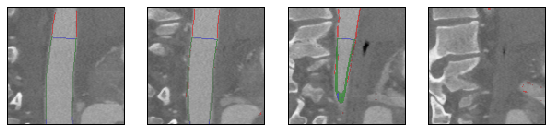

In [75]:
plt.rcParams['image.interpolation'] = 'nearest'
matched = (matchG>0)*(GT>0)
missed = (matchG==0)*(GT>0)
false = (matchE==0)*(Et>0)
fig = plt.figure(figsize = (80,80))
plot_vol_overlay(normalimg(I),
                 green=matched,
                 blue=missed,
                 red=false,
                 num_frames=4)